# Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from glob import glob


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_assignment/Train/")
data_dir_test = pathlib.Path('CNN_assignment/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                              image_size=(img_height,img_width),subset='training',
                                                               label_mode='categorical',
                                                               validation_split=0.2,seed=123)

##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=batch_size,
                                                            image_size=(img_height,img_width),subset='training',
                                                            label_mode='categorical',validation_split=0.2,seed=123)

##todo

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

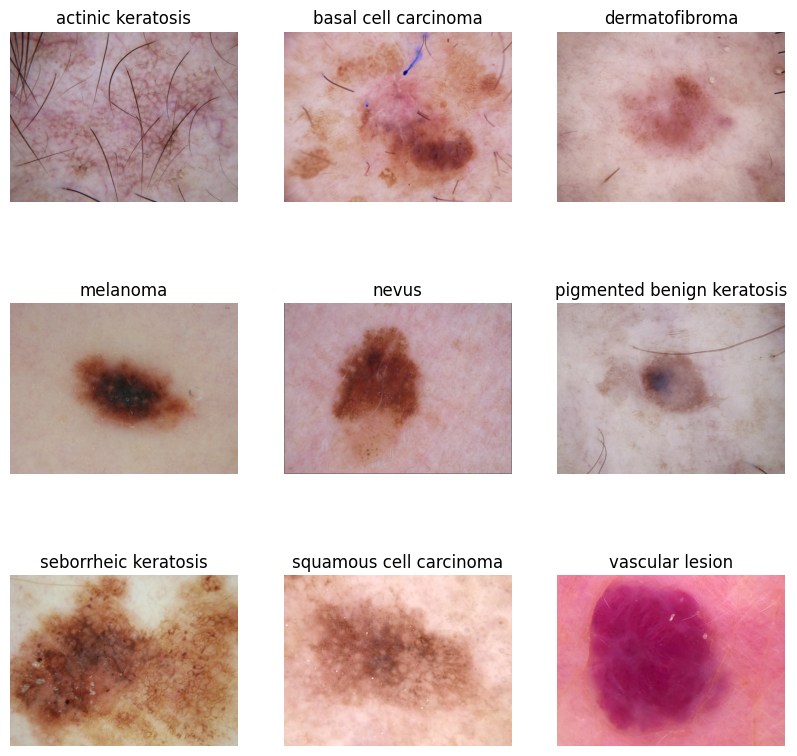

In [9]:
import matplotlib.pyplot as plt
class_len = len(class_names)
### Your code goes here
plt.figure(figsize=(10,10))
for i in range(class_len):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 38s 598ms/step - loss: 2.1160 - accuracy: 0.1931 - val_loss: 2.1253 - val_accuracy: 0.2211
Epoch 2/20
56/56 [==============================] - 33s 584ms/step - loss: 1.8930 - accuracy: 0.3125 - val_loss: 2.1360 - val_accuracy: 0.2211
Epoch 3/20
56/56 [==============================] - 33s 582ms/step - loss: 1.5890 - accuracy: 0.4464 - val_loss: 2.2211 - val_accuracy: 0.2421
Epoch 4/20
56/56 [==============================] - 33s 581ms/step - loss: 1.5096 - accuracy: 0.4542 - val_loss: 2.3154 - val_accuracy: 0.3053
Epoch 5/20
56/56 [==============================] - 32s 580ms/step - loss: 1.4134 - accuracy: 0.5073 - val_loss: 1.8848 - val_accuracy: 0.3474
Epoch 6/20
56/56 [==============================] - 33s 598ms/step - loss: 1.3670 - accuracy: 0.5073 - val_loss: 2.3561 - val_accuracy: 0.2842
Epoch 7/20
56/56 [==============================] - 34s 601ms/step - loss: 1.3156 - accuracy: 0.5329 - val_loss: 2.0445 - val_accuracy: 0.3579

### Visualizing training results

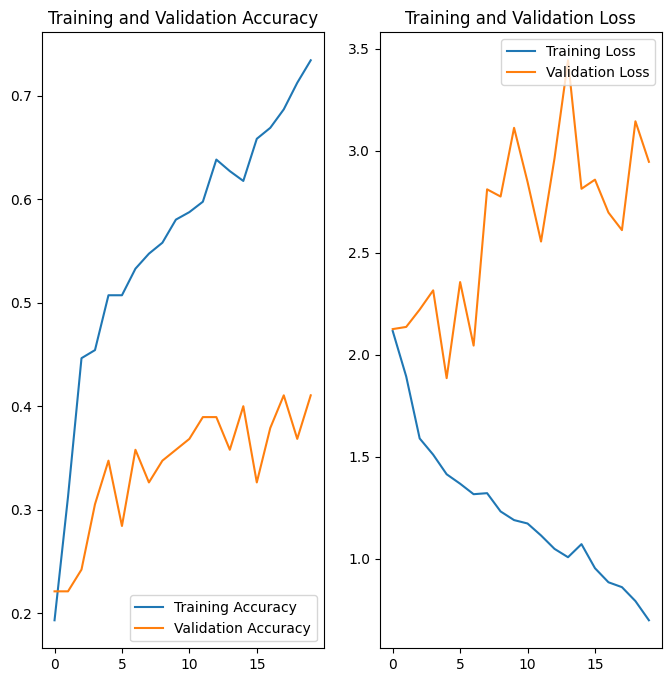

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Observations
There is clearly evidence of overfitting, with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

There is clearly evidence of overfitting, with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

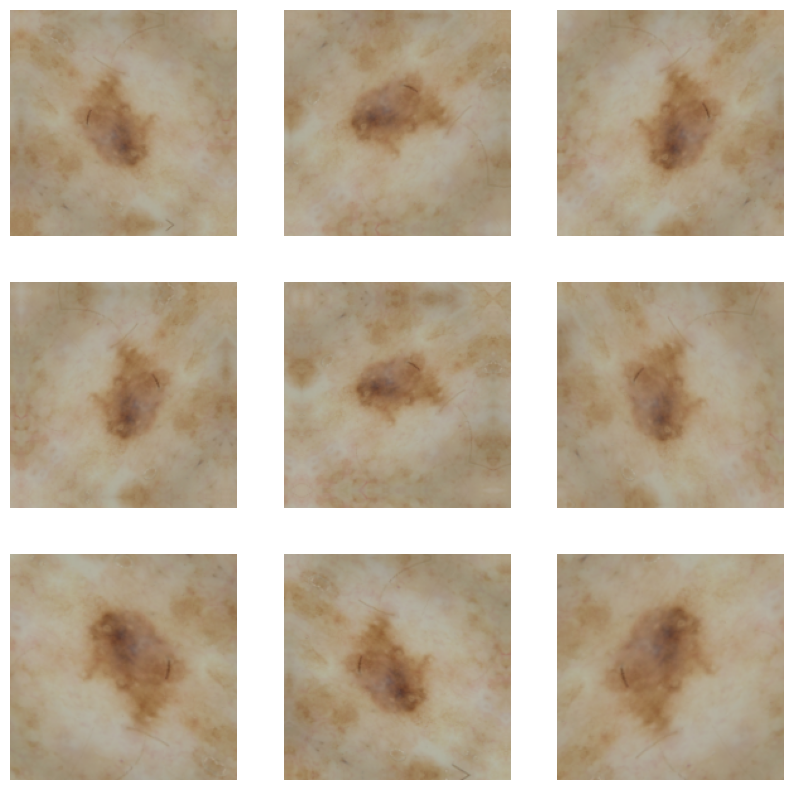

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  

model = Sequential()

# Data Augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)

#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Second Convulation Layer
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Third Convulation Layer
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#Fourth Convulation Layer
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#Fifth Convulation Layer
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Sixth Convulation Layer
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Seventh Convulation Layer
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Flatten Layer
model.add(Flatten())



#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [21]:
## Your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
 ## your training code
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 42s 732ms/step - loss: 2.0811 - accuracy: 0.1724 - val_loss: 2.1583 - val_accuracy: 0.1474 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 40s 715ms/step - loss: 2.0389 - accuracy: 0.1920 - val_loss: 2.1694 - val_accuracy: 0.1579 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 41s 730ms/step - loss: 2.0238 - accuracy: 0.2003 - val_loss: 2.2123 - val_accuracy: 0.1263 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 41s 725ms/step - loss: 2.0180 - accuracy: 0.1881 - val_loss: 2.2529 - val_accuracy: 0.1263 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 40s 707ms/step - loss: 2.0223 - accuracy: 0.1981 - val_loss: 2.2323 - val_accuracy: 0.1263 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 40s 714ms/step - loss: 2.0185 - accuracy: 0.2015 - val_loss: 2.2336 - val_accuracy: 0.1263 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - ETA: 0s - lo

### Visualizing the results

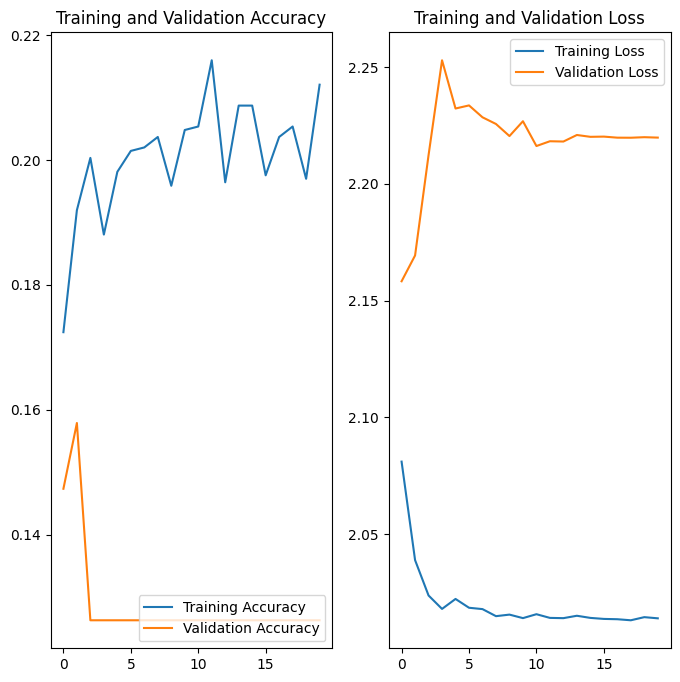

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

As can be seen, the model with augmentation layers and dropouts does not perform better on the training data, actually performing significantly worse. The model still performs poorly during inference using the validation set. There is some improvement, but the model is still overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.

In [25]:
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


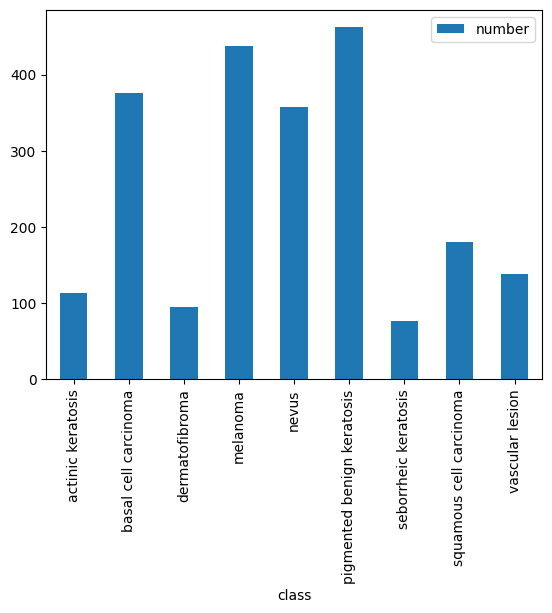

In [26]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


seborrheic keratosis has least number of samples.

pigmented benign keratosis class dominate in term proportionate number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
import Augmentor

In [29]:
path_to_training_dataset="CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28C34000CA0>: 100%|█| 500/500 [00:02<00:00, 215.28 Samples


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28C24AAC3D0>: 100%|█| 500/500 [00:02<00:


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28C0C8AB940>: 100%|█| 500/500 [00:02<00:00, 225.89 Samples


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x28C7ECE9700>: 100%|█| 500/500 [00:12<00:00, 39.66 Sample


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x28C7E9E9DC0>: 100%|█| 500/500 [00:12<00:00, 39.66 Samples/


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28C7ECF20D0>: 100%|█| 500/500 [00:02<00:


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x28C7ECB5100>: 100%|█| 500/500 [00:05<00:00, 85.88 Samples


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28C0C8727C0>: 100%|█| 500/500 [00:02<00:00, 172.44 Samples


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28C0C8B2340>: 100%|█| 500/500 [00:02<00:00, 233.70 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
data_dir_train

WindowsPath('CNN_assignment/Train')

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [32]:
path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))

['CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ac77a50b-b49e-49d3-8b30-37b1ed2817dc.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_47bad82f-3631-44c8-8114-616438624bc8.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_6a87810f-b7a0-465d-a438-97331a5da7b2.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_be934641-5df5-4e4c-8ecb-9b51cbf27274.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_cd4cae3c-dc03-477b-a1cd-f1ea88bdb774.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_dc08ad71-962c-4373-b099-a034dd3d1794.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025953.jpg_160e94cc-6b17-4309-aba3-934bfe1d92ed.jpg',
 'CNN_assignment\\Train\\ac

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()

,Path,Label
0,CNN_assignment\Train\actinic keratosis\output\...,actinic keratosis
1,CNN_assignment\Train\actinic keratosis\output\...,actinic keratosis
2,CNN_assignment\Train\actinic keratosis\output\...,actinic keratosis
3,CNN_assignment\Train\actinic keratosis\output\...,actinic keratosis
4,CNN_assignment\Train\actinic keratosis\output\...,actinic keratosis


In [36]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [37]:
for i in class_names:
    directory ='CNN_assignment/Train'
    directory_out ='CNN_assignment/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
data_dir_train="CNN_assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  "training",
  ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [42]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [43]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 112s 659ms/step - loss: 2.1500 - accuracy: 0.1832 - val_loss: 1.7391 - val_accuracy: 0.3593
Epoch 2/30
169/169 [==============================] - 111s 658ms/step - loss: 1.6258 - accuracy: 0.3819 - val_loss: 1.4388 - val_accuracy: 0.4491
Epoch 3/30
169/169 [==============================] - 112s 659ms/step - loss: 1.4680 - accuracy: 0.4438 - val_loss: 1.3190 - val_accuracy: 0.5122
Epoch 4/30
169/169 [==============================] - 109s 644ms/step - loss: 1.3520 - accuracy: 0.4818 - val_loss: 1.2985 - val_accuracy: 0.5011
Epoch 5/30
169/169 [==============================] - 110s 651ms/step - loss: 1.2282 - accuracy: 0.5287 - val_loss: 1.3135 - val_accuracy: 0.5137
Epoch 6/30
169/169 [==============================] - 109s 642ms/step - loss: 1.2056 - accuracy: 0.5495 - val_loss: 1.1642 - val_accuracy: 0.5516
Epoch 7/30
169/169 [==============================] - 111s 656ms/step - loss: 1.1094 - accuracy: 0.5820 - val_loss: 1.0918 -

#### **Todo:**  Visualize the model results

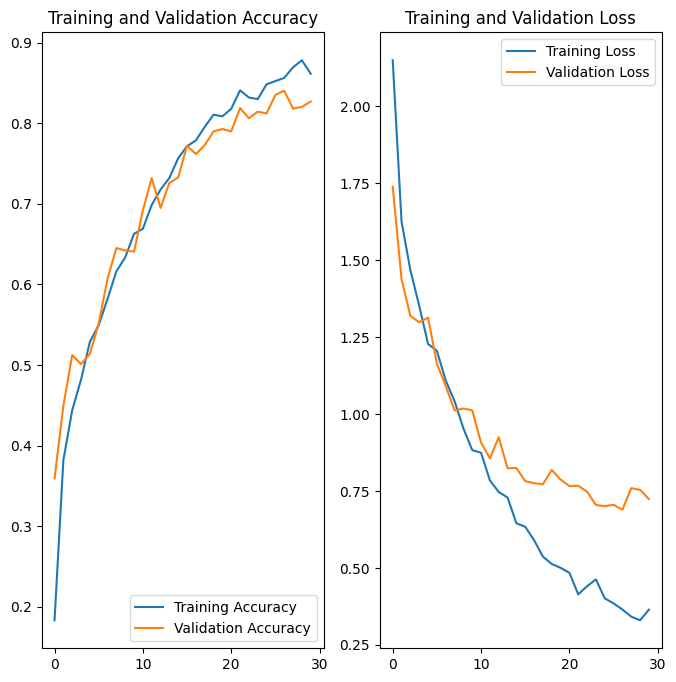

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of 0.8782 at 30 epochs, and validation accuracy at 0.8404.

In [45]:
# Let try Reduce learning rate callback

In [50]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  

model2 = Sequential()

#First Convulation layer
model2.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))) 
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))

#Second Convulation Layer
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))

#Third Convulation Layer
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))

#Fourth Convulation Layer
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.5))


#Flatten Layer
model2.add(layers.Flatten())

#Dense Layer 1
model2.add(layers.Dense(256,activation='relu'))


model2.add(layers.Dropout(0.25))

#Dense Layer 2
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Dense Layer 3
model2.add(layers.Dense(64,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 41, 41, 128)      

In [51]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
## Your code goes here, note: train your model for 30 epochs
 ## your training code
epochs = 50
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50
169/169 [==============================] - 159s 933ms/step - loss: 2.1672 - accuracy: 0.1586 - val_loss: 2.0646 - val_accuracy: 0.1544 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 155s 918ms/step - loss: 1.9939 - accuracy: 0.2148 - val_loss: 1.8285 - val_accuracy: 0.2888 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 156s 921ms/step - loss: 1.8220 - accuracy: 0.2980 - val_loss: 1.6125 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 157s 929ms/step - loss: 1.6701 - accuracy: 0.3464 - val_loss: 1.6576 - val_accuracy: 0.3749 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 157s 926ms/step - loss: 1.5930 - accuracy: 0.3885 - val_loss: 1.4675 - val_accuracy: 0.4358 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 156s 924ms/step - loss: 1.5417 - accuracy: 0.3987 - val_loss: 1.4548 - val_accuracy: 0.4365 - lr: 0.0010
Epoch 7/50
169/169 [==========================

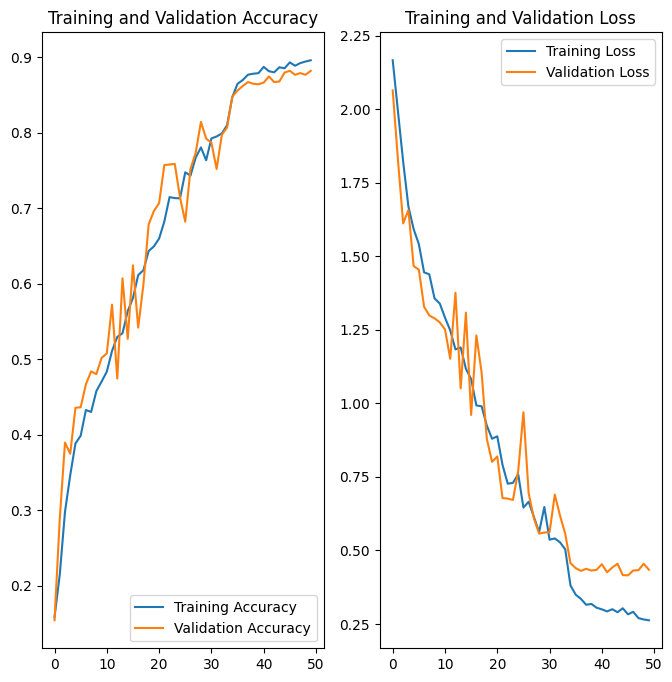

In [53]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 Our Training score and Validation score is much closer as compare previous model when we try to control the
learning rate using learn control.

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of 0.8960 at 50 epochs, and validation accuracy at 0.8820. Judging by the large fluctuations in the validation loss, it is recommended to rerun the training with a reducing learning rate. The model seems to be jumping around a local minimum.Possibly including some other callback to reduce the learning rate once an accuracy of 0.8 has been reached may lead to improvements.